# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
%cd /content/drive/MyDrive/results/coco-caption

%matplotlib inline
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

/content/drive/MyDrive/results/coco-caption


# Load Dataset

In [ ]:
%cd /content/drive/MyDrive/results
import pickle
import nltk
nltk.download('punkt')

with open('./imageCaptions/vanilla_lstm_results2.pkl', 'rb') as f:
  vanilla_lstm_results = pickle.load(f)

/content/drive/MyDrive/results
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
with open('./imageCaptions/vanilla_lstm_result_ids2.pkl', 'rb') as f:
  vanilla_lstm_result_ids = pickle.load(f)

In [ ]:
# Read adjective list
filename = 'anp_list.txt'

with open(filename, 'r') as f:
    lines = f.readlines()

anp = []

for i in range(0,len(lines)):
    anp.append(lines[i].rsplit(' ',1)[0])
  
anps = list(set(anp))

# Create generated sentence without adjectives

In [ ]:
# Setence without adjectives
senTocompare = []

for i in range(0,len(vanilla_lstm_results)):
  tokens = nltk.tokenize.word_tokenize(vanilla_lstm_results[i].lower())
  tokensNotadjs = [t for t in tokens if t not in anps]
  withoutAdjs = " ".join(tokensNotadjs)
  senTocompare.append(withoutAdjs)

In [ ]:
# Load original captions
import json

with open('./captions_val2014.json') as json_file:
    captions_val2014 = json.load(json_file)

In [ ]:
# Find image ids
image_ids = [] 

for i in range(0,len(vanilla_lstm_result_ids)):
  for j in range(0,len(captions_val2014['images'])):
    if vanilla_lstm_result_ids[i] == captions_val2014['images'][j]['file_name']:
      image_ids.append(captions_val2014['images'][j]['id'])

In [ ]:
# Create Json file for generated sentences
import collections
sendict = []

for i in range(0,len(image_ids)):
  dict_temp = {'image_id': image_ids[i],
               'caption': senTocompare[i]}
  od = collections.OrderedDict(sorted(dict_temp.items(), reverse=True))
  sendict.append(od)

In [ ]:
with open('vanilla_lstm_generated_sen.json', 'w') as outfile:
  json.dump(sendict, outfile)

# Load created dataset

In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
# set up file names and pathes
# Data Directory
groud_truth = './coco-caption/annotations/captions_val2014.json'
generated_sen = './vanilla_lstm_generated_sen.json'

## I don't know whether this stanford model is needed
# download Stanford models
%cd /content/drive/MyDrive/results/coco-caption
!./get_stanford_models.sh

/content/drive/MyDrive/results/coco-caption
Found Stanford CoreNLP.


In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
## COCO reads original COCO style file: captions_val2014.json 
## loadRes reads load Id and caption json file
## Example: {"image_id": 404464, "caption": "black and white photo of a man standing in front of a building"}

%cd /content/drive/MyDrive/results
ground_truth = COCO(groud_truth)
gen_sen = ground_truth.loadRes(generated_sen)

/content/drive/MyDrive/results
loading annotations into memory...
0:00:00.779439
creating index...
index created!
Loading and preparing results...     
DONE (t=0.04s)
creating index...
index created!


# Calculate evaluation metrics

In [ ]:
%cd /content/drive/MyDrive/results/coco-caption

/content/drive/MyDrive/results/coco-caption


In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
# create cocoEval object by taking coco and cocoRes
#cocoEval = COCOEvalCap(coco, cocoRes)
cocoEval = COCOEvalCap(ground_truth, gen_sen)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
#cocoEval.params['image_id'] = cocoRes.getImgIds()
cocoEval.params['image_id'] = gen_sen.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 951, 'guess': [913, 813, 713, 613], 'testlen': 913, 'correct': [306, 57, 13, 4]}
ratio: 0.960042060987
Bleu_1: 0.321
Bleu_2: 0.147
Bleu_3: 0.072
Bleu_4: 0.039
computing METEOR score...
METEOR: 0.102
computing Rouge score...
ROUGE_L: 0.211
computing CIDEr score...
CIDEr: 0.183
computing SPICE score...
SPICE: 0.055


In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print '%s: %.4f'%(metric, score)

CIDEr: 0.1827
Bleu_4: 0.0392
Bleu_3: 0.0723
Bleu_2: 0.1470
Bleu_1: 0.3215
ROUGE_L: 0.2105
METEOR: 0.1021
SPICE: 0.0546


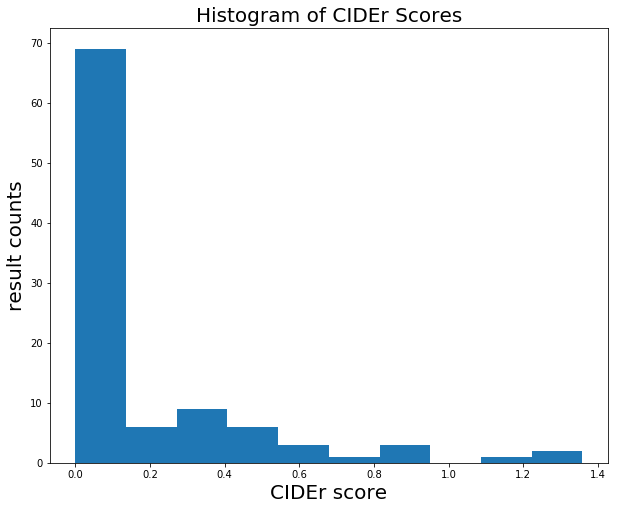

In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [ ]:
# From: https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb
# save evaluation results to ./results folder
'''
import os
%cd /content/drive/MyDrive/results/evalresults
evalImgsFile = './vinalla_lstm_imgresults.json'
evalFile = './vinalla_lstm_lstm_evalresults.json'

json.dump(cocoEval.evalImgs, open(evalImgsFile, 'w'))
json.dump(cocoEval.eval,     open(evalFile, 'w'))
'''

/content/drive/MyDrive/results/evalresults
